In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
from torch.utils.data import DataLoader
from transformer_model import Transformer
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt

In [2]:
df_vid = pd.read_csv("master_features.csv", header=0, names=["id", "emb","keystep"])

In [3]:
df_text = pd.read_csv("reviewed_0812.csv")

In [4]:
def convert_to_arr(input_str, dim):
    if dim == 1:
        input_str = input_str[1:-1]
    elif dim == 2:
        input_str = input_str.replace(" ", "")  # Remove spaces
        input_str = input_str.replace("][", "],[")  # Add commas between sub-arrays
    else:
        raise NotImplementedError

    # Evaluating the string to create a nested list
    nested_list = eval(input_str)

    # Converting the nested list to a numpy array
    np_array = np.array(nested_list)
    return np_array

In [5]:
def get_id(url):
    url_parts = url.split("?")

    # Extracting the query parameters part of the URL
    query_params = url_parts[1] if len(url_parts) > 1 else ""

    # Splitting the query parameters by "&" to separate individual key-value pairs
    query_params = query_params.split("&")

    # Extracting the video ID from the query parameters
    video_id = ""
    for param in query_params:
        if param.startswith("v="):
            video_id = param[2:]
        break
    return video_id

In [6]:
df_text["VideoID"] = df_text["VideoUrl"].apply(get_id)

In [8]:
data_pkl = {}
for i in range(df_vid.shape[0]):
    vid_name, vid_arr, vid_key = df_vid.iloc[i][0], convert_to_arr(df_vid.iloc[i][1],dim=2), convert_to_arr(df_vid.iloc[i][2],dim=1)
    matches = df_text["VideoID"].str.contains(vid_name)
    # assert vid_arr.shape[0] == len(df_text.loc[matches]["Sentence"].values)
    data_pkl[vid_name] = {}
    data_pkl[vid_name]["Sentence"] = df_text.loc[matches]["Sentence"].values
    data_pkl[vid_name]["IsUsefulSentence"] = df_text.loc[matches]["IsUsefulSentence"].values
    data_pkl[vid_name]["Key steps"] = df_text.loc[matches]["Key steps"].values
    data_pkl[vid_name]["Verb"] = df_text.loc[matches]["Verb"].values
    data_pkl[vid_name]["Object"] = df_text.loc[matches]["Object(directly related with Verb)"].values
    data_pkl[vid_name]["img_feat"] = vid_arr

In [9]:
with open("img_text_comb_updated.pkl", "wb") as f:
    pkl.dump(data_pkl, f)

In [10]:
with open("img_text_comb_updated.pkl", "rb") as f:
    data_pkl = pkl.load(f)

In [11]:
from sentence_transformers import SentenceTransformer

/home/mila/s/subhrajyoti.dasgupta/.conda/envs/quick_recipe/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [13]:
from tqdm import tqdm as tqdm

In [14]:
for key in tqdm(data_pkl.keys()):
    sentences = data_pkl[key]["Sentence"]
    embeddings = model.encode(sentences)
    data_pkl[key]["text_emb(all-MiniLM-L6-v2)"] = embeddings

100%|██████████| 351/351 [00:09<00:00, 36.84it/s]


In [15]:
from sklearn.metrics import pairwise_distances

In [16]:
cosine_dist = pairwise_distances(embeddings, metric="cosine")

In [17]:
for i in range(10):
    min_dist = np.argsort(cosine_dist[i])[1]
    print(f"{sentences[i]} |||||| {sentences[min_dist]}")
    print("-------")

hi , i 'm caroline, miliotis. |||||| anna save, i 'm going to pour it all through the sieve.
-------
and i 'm going to show you how to make your very own lack to start with. |||||| all you have to do.
-------
we need to make us myspace, so we 're doing this one from scratch, now i 'm going to pop into my blender. |||||| let 's blend this until it 's really fine paste in a large pan.
-------
make sure lots full cloves of garlic handful of macadamia nuts. |||||| now i 'm using macadamia nuts.
-------
now i 'm using macadamia nuts. |||||| make sure lots full cloves of garlic handful of macadamia nuts.
-------
because i ca n't get hold of any candlenuts here. |||||| but in malaysia, they would use candle nuts and macadamia nuts are the closest thing to it.
-------
but in malaysia, they would use candle nuts and macadamia nuts are the closest thing to it. |||||| now i 'm using macadamia nuts.
-------
two stalks of lemongrass with the outer shell, taken off. |||||| and i have some finely cho

In [18]:
split_df = pd.read_csv("/network/scratch/j/jonathan.lim/IFT6759_Adv_Proj/quick-recipe/data/train_val_split.csv")

In [19]:
train_url = split_df[split_df.Split == "train"]["VideoUrl"]
val_url = split_df[split_df.Split == "val"]["VideoUrl"]

In [20]:
train_id = list(map(get_id, train_url))
val_id = list(map(get_id, val_url))

In [21]:
train_data = {}
test_data = {}

In [22]:
for v_id in train_id:
    if v_id not in data_pkl.keys():
        print(v_id)
        continue
    else:
        train_data[v_id] = data_pkl[v_id]

Vy5ypC9_cOs


In [23]:
for v_id in val_id:
    if v_id not in data_pkl.keys():
        print(v_id)
        continue
    else:
        test_data[v_id] = data_pkl[v_id]

In [24]:
import torch

class YouCookData(torch.utils.data.Dataset):
    def __init__(self, data, seq_len = 136):
        # Merge resnet feat + text --> S, D --> Pad till 136 --> Return inp + mask
        self.input = []
        self.mask = []
        self.labels = []
        i=0
        for vid_name in tqdm(data.keys()):
            txt_emb = data[vid_name]["text_emb(all-MiniLM-L6-v2)"]
            img_emb = data[vid_name]["img_feat"]
            label = np.array(data[vid_name]["IsUsefulSentence"])
            if txt_emb.shape[0] !=  img_emb.shape[0]:
                print(vid_name)
                i += 1
                continue
            concat_emb = np.concatenate((txt_emb, img_emb), axis=1)
            concat_emb = img_emb
            len_story = concat_emb.shape[0]
            if len_story < seq_len:
                padding = np.zeros((seq_len-len_story, concat_emb.shape[1]))
                concat_emb = np.concatenate((concat_emb, padding), axis=0)
                label = np.concatenate((label, -1*np.ones(seq_len-len_story)))
                
            mask = np.zeros(seq_len)
            mask[:len_story] = 1
            self.input.append(concat_emb)
            self.mask.append(mask)
            self.labels.append(label)
            print('======',concat_emb.shape)
            print('======',label.shape)

    def __getitem__(self, idx):
        return torch.from_numpy(self.input[idx]), torch.from_numpy(self.mask[idx]), torch.from_numpy(self.labels[idx])

    def __len__(self):
        return len(self.labels)

In [25]:
len(train_data.keys()), len(test_data.keys())

(252, 99)

In [26]:
train_dataset = YouCookData(train_data)
test_dataset = YouCookData(test_data)

100%|██████████| 252/252 [00:00<00:00, 2852.52it/s]


====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
5nh2CP22dgY
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (13

100%|██████████| 99/99 [00:00<00:00, 2702.46it/s]

====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
okvTq8gtr8c
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (136,)
====== (136, 512)
====== (13

In [28]:
batchsize=64
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

In [44]:
def train_one_epoch(model: torch.nn.Module, training_data_loader: DataLoader, optimizer: torch.optim.Optimizer, logging_frequency: int, testing_data_loader: DataLoader, logger: dict):
    model.train()
    optimizer.zero_grad()
    epoch_loss = 0
    logging_loss = 0
    start_time = time.time()
    mini_start_time = time.time()
    for step, batch in enumerate(training_data_loader):
        inp, mask, label = batch
        inp = inp.float().cuda()
        mask = mask.long().cuda()
        label = label.long().cuda()
        
        outputs = model(inp, mask, label)
        loss = outputs[0]
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        logging_loss += loss.item()
        
    print("Running Evaluation Step")
    eval_f1, eval_loss = evaluate(model, testing_data_loader)
    
    print(f"Evaluation Loss, F1: {eval_loss}, {eval_f1}")
    return epoch_loss / len(training_data_loader), eval_loss, eval_f1


def evaluate(model: torch.nn.Module, test_data_loader: DataLoader):
    model.eval()
    eval_loss = 0
    correct_predictions = {i: 0 for i in range(2)}
    total_predictions = {i: 0 for i in range(2)}
    start_time = time.time()
    targets = []
    prediction_list= []
    with torch.no_grad():
        for step, batch in enumerate(test_data_loader):
            inp, mask, label = batch
            inp = inp.float().cuda()
            mask = mask.long().cuda()
            label = label.long().cuda()
            outputs = model(inp, mask, label)
            loss = outputs[0]
            eval_loss += loss.item()
            predictions = np.argmax(outputs[1].detach().cpu().numpy(), axis=2)
            
            target = label.cpu().numpy()
            target_mask = target != -1
            
            target = target[target_mask]
            predictions = predictions[target_mask]
            
            targets.extend(list(target))
            prediction_list.extend(list(predictions))
    
    targets = np.array(targets)
    prediction_list = np.array(prediction_list)

    print(classification_report(targets, prediction_list))
    
    f1 = f1_score(targets, prediction_list, labels=[1])
    model.train()
    return f1,  eval_loss / len(test_data_loader)

In [45]:
def get_logger(model):
    logger = dict()
    logger['train_losses'] = []
    logger['eval_f1'] = []
    logger['eval_losses'] = []
    return logger

In [46]:
def save_logs(dictionary, log_dir, exp_id):
    log_dir = os.path.join(log_dir, exp_id)
    os.makedirs(log_dir, exist_ok=True)
    # Log arguments
    with open(os.path.join(log_dir, "args.json"), "w") as f:
        json.dump(dictionary, f, indent=2)


In [47]:
import time,os,json

In [53]:
learning_rate = 1e-4
num_epochs = 50
logging_frequency = 10
model = Transformer(embed_dim=512, num_heads=1, num_layers=1, block='postnorm', dropout=0.3)
model.cuda()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, eps=1e-8)    
logger = get_logger(model)
best_f1=0
best_epoch = 0
for i in range(num_epochs):
    train_loss, val_loss, val_f1 = train_one_epoch(model, train_loader, optimizer, logging_frequency, test_loader, logger)
    print("Train loss: {}".format(train_loss))
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_epoch = i
        torch.save(model.state_dict(),"../models/attention_keyclip/best_model1.pkl")
        
    logger['train_losses'].append(train_loss)
    logger['eval_losses'].append(val_loss)
    logger['eval_f1'].append(val_f1)
    save_logs(logger, "../logs/attention_keyclip", "1")
    

Running Evaluation Step
              precision    recall  f1-score   support

           0       0.77      0.92      0.84      3346
           1       0.25      0.09      0.13      1000

    accuracy                           0.73      4346
   macro avg       0.51      0.50      0.48      4346
weighted avg       0.65      0.73      0.68      4346

Evaluation Loss, F1: 0.6081753671169281, 0.12998522895125553
Train loss: 0.7016224265098572
Running Evaluation Step
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      3346
           1       0.35      0.01      0.01      1000

    accuracy                           0.77      4346
   macro avg       0.56      0.50      0.44      4346
weighted avg       0.67      0.77      0.67      4346

Evaluation Loss, F1: 0.6720892786979675, 0.011799410029498525
Train loss: 0.6111238449811935
Running Evaluation Step
              precision    recall  f1-score   support

           0       0.77      1.00 

/home/mila/s/subhrajyoti.dasgupta/.conda/envs/quick_recipe/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mila/s/subhrajyoti.dasgupta/.conda/envs/quick_recipe/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mila/s/subhrajyoti.dasgupta/.conda/envs/quick_recipe/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

Running Evaluation Step
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      3346
           1       0.00      0.00      0.00      1000

    accuracy                           0.77      4346
   macro avg       0.38      0.50      0.43      4346
weighted avg       0.59      0.77      0.67      4346

Evaluation Loss, F1: 0.6361521184444427, 0.0
Train loss: 0.6118389219045639
Running Evaluation Step
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      3346
           1       0.35      0.01      0.01      1000

    accuracy                           0.77      4346
   macro avg       0.56      0.50      0.44      4346
weighted avg       0.67      0.77      0.67      4346

Evaluation Loss, F1: 0.5665107071399689, 0.013725490196078431
Train loss: 0.5807770639657974
Running Evaluation Step
              precision    recall  f1-score   support

           0       0.77      0.98      0.86      3

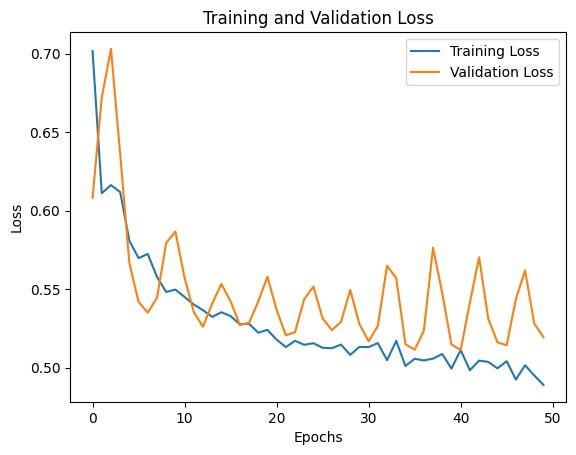

In [54]:
epochs = range(num_epochs)
 
# Plot and label the training and validation loss values
plt.plot(epochs, logger["train_losses"], label='Training Loss')
plt.plot(epochs, logger['eval_losses'], label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
# plt.xticks(arange(0, 21, 2))
 
# Display the plot
plt.legend(loc='best')
plt.show()

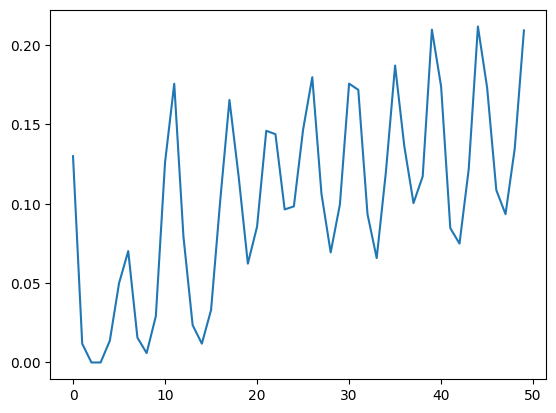

In [55]:
plt.figure()
plt.plot(epochs, logger["eval_f1"], label='Eval f1')
plt.show()

In [56]:
model.load_state_dict(torch.load("../models/attention_keyclip/best_model1.pkl"))
a,b = evaluate(model, test_loader)
del model

              precision    recall  f1-score   support

           0       0.79      0.95      0.86      3346
           1       0.44      0.14      0.21      1000

    accuracy                           0.76      4346
   macro avg       0.62      0.54      0.54      4346
weighted avg       0.71      0.76      0.71      4346



In [57]:
learning_rate = 1e-4
num_epochs = 50
logging_frequency = 10
model = Transformer(embed_dim=512, num_heads=4, num_layers=4, block='prenorm', dropout=0.3)
model.cuda()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, eps=1e-8)    
logger = get_logger(model)
best_f1=0
best_epoch = 0
for i in range(num_epochs):
    train_loss, val_loss, val_f1 = train_one_epoch(model, train_loader, optimizer, logging_frequency, test_loader, logger)
    print("Train loss: {}".format(train_loss))
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_epoch = i
        torch.save(model.state_dict(),"../models/attention_keyclip/best_model1.pkl")
        
    logger['train_losses'].append(train_loss)
    logger['eval_losses'].append(val_loss)
    logger['eval_f1'].append(val_f1)
    save_logs(logger, "../logs/attention_keyclip", "1")
    

Running Evaluation Step
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      3346
           1       1.00      0.00      0.00      1000

    accuracy                           0.77      4346
   macro avg       0.89      0.50      0.44      4346
weighted avg       0.82      0.77      0.67      4346

Evaluation Loss, F1: 0.7505573928356171, 0.0019980019980019984
Train loss: 0.6997956484556198
Running Evaluation Step
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      3346
           1       0.00      0.00      0.00      1000

    accuracy                           0.77      4346
   macro avg       0.38      0.50      0.43      4346
weighted avg       0.59      0.77      0.67      4346

Evaluation Loss, F1: 0.9243012964725494, 0.0
Train loss: 0.6360828131437302


/home/mila/s/subhrajyoti.dasgupta/.conda/envs/quick_recipe/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mila/s/subhrajyoti.dasgupta/.conda/envs/quick_recipe/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mila/s/subhrajyoti.dasgupta/.conda/envs/quick_recipe/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

Running Evaluation Step
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      3346
           1       0.00      0.00      0.00      1000

    accuracy                           0.77      4346
   macro avg       0.38      0.50      0.43      4346
weighted avg       0.59      0.77      0.67      4346

Evaluation Loss, F1: 0.7117505073547363, 0.0
Train loss: 0.6252922862768173


/home/mila/s/subhrajyoti.dasgupta/.conda/envs/quick_recipe/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mila/s/subhrajyoti.dasgupta/.conda/envs/quick_recipe/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mila/s/subhrajyoti.dasgupta/.conda/envs/quick_recipe/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

Running Evaluation Step
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      3346
           1       0.65      0.01      0.02      1000

    accuracy                           0.77      4346
   macro avg       0.71      0.50      0.45      4346
weighted avg       0.74      0.77      0.68      4346

Evaluation Loss, F1: 0.5479767322540283, 0.021632251720747297
Train loss: 0.5728897005319595
Running Evaluation Step
              precision    recall  f1-score   support

           0       0.78      0.96      0.86      3346
           1       0.44      0.11      0.18      1000

    accuracy                           0.76      4346
   macro avg       0.61      0.53      0.52      4346
weighted avg       0.70      0.76      0.70      4346

Evaluation Loss, F1: 0.5304914712905884, 0.17979315831344472
Train loss: 0.5664670169353485
Running Evaluation Step
              precision    recall  f1-score   support

           0       0.78      0.96 

In [58]:
model.load_state_dict(torch.load("../models/attention_keyclip/best_model1.pkl"))
a,b = evaluate(model, test_loader)
del model

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      3346
           1       0.35      0.38      0.36      1000

    accuracy                           0.70      4346
   macro avg       0.58      0.58      0.58      4346
weighted avg       0.70      0.70      0.70      4346

